# Laser Sensor Outdoor Tests

## Objective

Determine Garmin's LIDAR Lite V4's capability in detecting and gauging distances of vehicles in genuine outdoor settings.

## Experiment Details

### Experiment Setup

1. **Stationary Test**: The sensor was initially mounted on a stationary bike alongside a busy road to gauge its proficiency in detecting passing vehicles.
2. **Dynamic Test**: Retaining the setup, the bike was ridden by a food delivery rider, collecting data from vehicles overtaking the cyclist. This step transitioned the evaluation from a controlled setting to a more dynamic environment, offering insights into real-world applicability.

### Data Extraction

- **Raspberry Pi**: As before, data from the sensor was published over to AWS IoT's message broker via MQTT. I then extracted the data in to text files. Each line of measurement contains the time, distance, and signal strength:

    ```text
    10:45:37 1623 4
    ```

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`outdoor_graphs.py`](../src/graphing/outdoor_graphs.py) provides utilities for data visualization.

In [1]:
import datetime
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

sys.path.append("../src")

from data import cleaner, loader
from graphing import outdoor_graphs

### Data Preparation and Loading

I load the data collected from the stationary tests.

In [2]:
YUAN_CHING_RD_1 = pathlib.Path("../data/processed/lidar_outdoor_tests/yuan_ching_rd_1.txt")
YUAN_CHING_RD_2 = pathlib.Path("../data/processed/lidar_outdoor_tests/yuan_ching_rd_2.txt")
JURONG_WEST_RIDE = pathlib.Path("../data/processed/lidar_outdoor_tests/jurong_west_ride.txt")

## Stationary Test

In the first test, the sensor was mounted on a stationary bike along Yuan Ching Rd. which saw moderate traffic. I also mounted a Go Pro to capture a video of the vehicles that passed the bike. I cross referenced the data collected from the sensor and the Go Pro's video feed to determine the reliability of the sensor.

### Raw Data Analysis 1

- **Scatter Plot Observations**: At a glance, the sensor appears to reliably detect passing vehicles as seen from the clusters of dark points on the graph. However, it also appears to generate spurious data as seen from the individual points scattered throughout the graph, especially above 3.5m.
- **Data Cleaning Objective**: Therefore, a cleaning algorithm could be used to improve the reliability of the sensor by removing these spurious points while keeping the clusters.

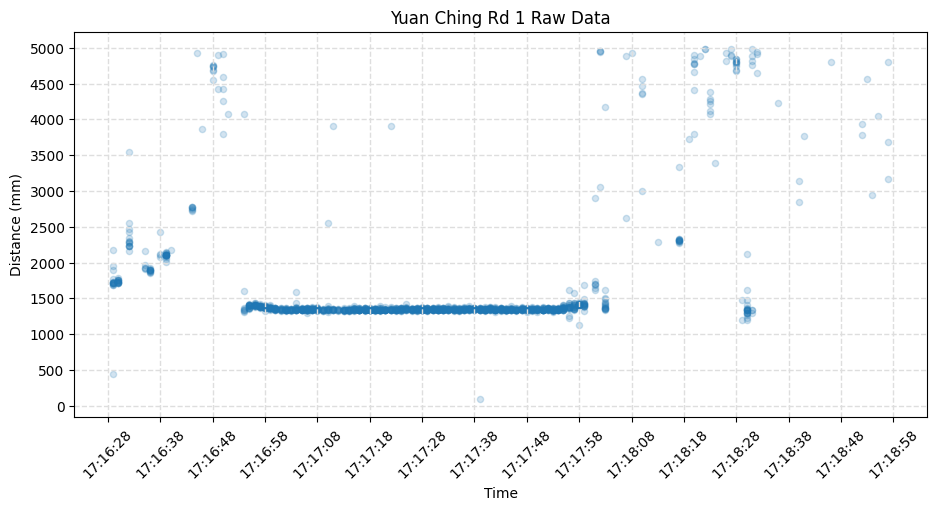

In [3]:
timings, distances, strengths = loader.filter_data_from_file(YUAN_CHING_RD_1, threshold=5000)

fig, axes = plt.subplots(figsize=(11, 5))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Yuan Ching Rd 1 Raw Data", intervals=10, rotate_xticks=True)
plt.show()

### Data Cleaning Algorithm

- **Cluster Identification**: Using the same cleaning algorithm as for the TOF sensor, distances that weren't in proximity (within two points) of other distances were removed, ensuring a minimum cluster size of 2 points.
- **Graphical Representation**: After cleaning, the spurious points appear to be removed while keeping the clusters representing the vehicle passes.

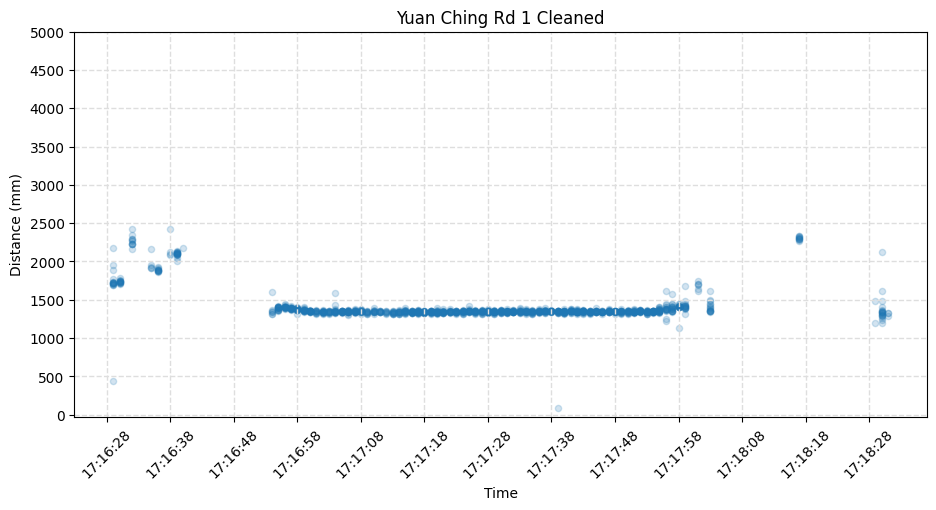

In [4]:
fig, axes = plt.subplots(figsize=(11, 5))
cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes, timings, cleaned_distances, "Yuan Ching Rd 1 Cleaned", intervals=10, rotate_xticks=True)
plt.show()

### Data Cross-Reference with Video Feed 1

- **General Observations**:
  - The cleaned data effectively pinpointed the clusters representing passing vehicles.
  - The first two clusters at 17:16:28 onwards were recorded before the video feed began.
  - The huge cluster circled in blue represented a stopped bus.
  - The sensor missed a vehicle between 17:18:08 to 17:18:18. However, this was due to the sensor's unstable I2C connection that saw it periodically pausing its measurements.
- **Speed Consideration**:
  - The LIDAR Lite sampled at a much higher frequency compared to the TOF and Laser sensors, allowing to to be record passing vehicles more reliably.

![LIDAR Yuan Ching Rd](../assets/annotated_graphs/LIDAR_yuan_ching_rd.png)

## Stationary Test with DepthAI Camera

During the second test, the DepthAI's AI camera was paired with the side LIDAR sensor. Utilizing the YOLO V6 detection network, the camera was calibrated to identify cars, buses, and trucks. Once a vehicle came into view, the LIDAR sensor gauged its distance. This configuration aimed to streamline the data collection process by eliminating the need for a Go Pro to verify a vehicle's proximity to the bicycle; the AI camera handled that autonomously. To assess the system's efficacy, I stationed the bike beside the same road as before, letting the sensors track approaching vehicles.

![LIDAR-DepthAI Setup](../assets/lidar_depthai_setup.jpeg)

### Raw Data Analysis 2

- **Scatter Plot Observations**: The LIDAR-DepthAI setup appears to reliably detect passing vehicles as seen from the clusters of dark points on the graph. Furthermore, the data is a lot more clean from cluster to cluster, as the setup does not detect vehicles when no cars are present in the AI camera's field of vision, leading to less spurious points. Nonetheless, from 3.5m and above, from the large increase in spurious points it can be inferred that the sensor loses some reliability.
- **Data Cleaning Objective**: However, the light clusters of points show that spurious measurements were still made. The same data cleaning algorithm should remove these points.

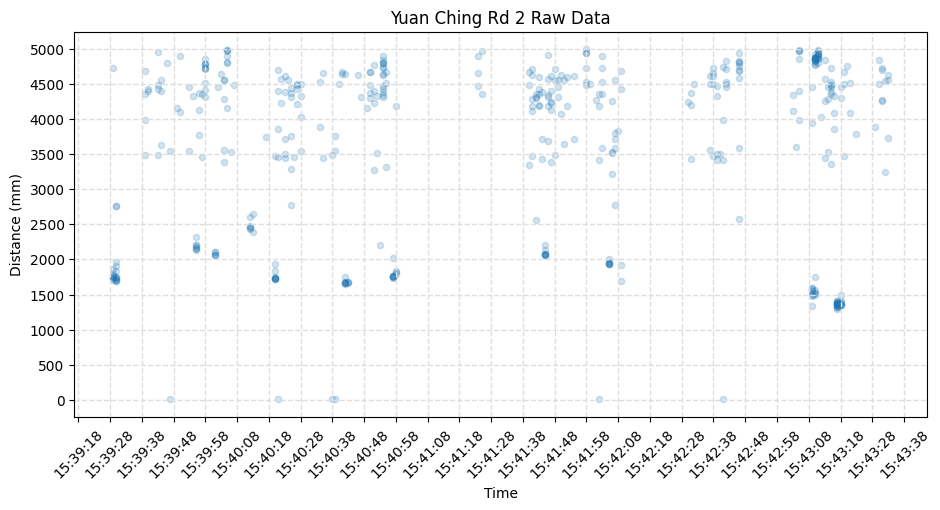

In [5]:
timings, distances, strengths = loader.filter_data_from_file(YUAN_CHING_RD_2, threshold=5000)

fig, axes = plt.subplots(figsize=(11, 5))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Yuan Ching Rd 2 Raw Data", intervals=10, rotate_xticks=True)
plt.show()

After cleaning, the graph is left with a few very distinct clusters representing vehicle passes.

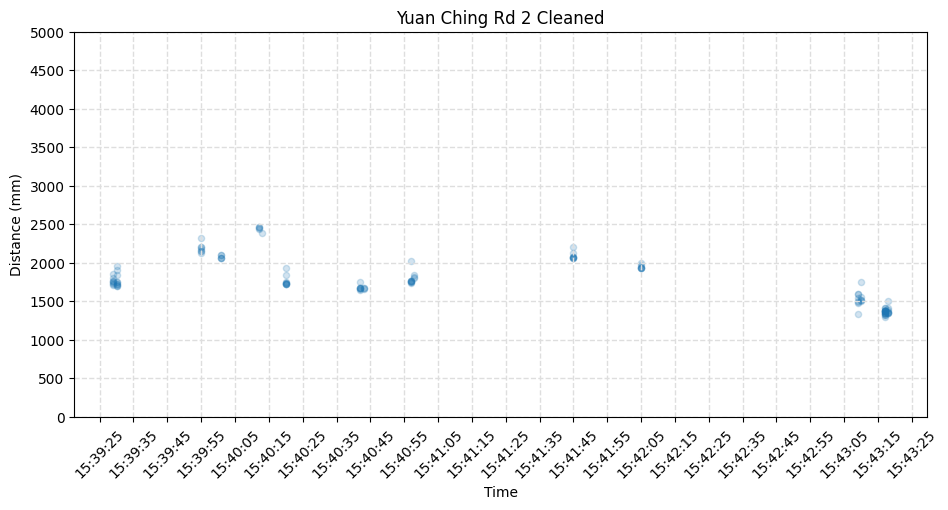

In [6]:
fig, axes = plt.subplots(figsize=(11, 5))
cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes, timings, cleaned_distances, "Yuan Ching Rd 2 Cleaned", intervals=10, rotate_xticks=True)
plt.show()

### Data Cross-Reference with Video Feed 2

- **General Observations**:
  - The cleaned data effectively pinpointed the clusters representing passing vehicles.
  - The first two clusters at 17:16:28 onwards were recorded before the video feed began.
  - The huge cluster circled in blue represented a stopped bus.
  - The sensor missed a vehicle between 17:18:08 to 17:18:18. However, this was due to the sensor's unstable I2C connection that saw it periodically pausing its measurements.
- **Speed Consideration**:
  - The LIDAR Lite sampled at a much higher frequency compared to the TOF and Laser sensors, allowing to to be record passing vehicles more reliably.

## On-Road Cycling Test

Finally, with the same setup, the bike was cycled along a 5km route alongside traffic in Singapore's Jurong West area. This experiment aims to demonstrate the effectiveness of the LIDAR-DepthAI setup in automatically collecting vehicle-to-cyclist passing distances.

### Jurong-West Ride Analysis

- **Setup and Initial Observations**:
  - The food delivery rider cycled a 5-6km loop on public roads exposed to traffic in the Jurong West area.
  - At a galnce it can be seen that the large majority of data points fall below the 1.5m mark, suggesting that many vehicles overtook the cyclist too close.

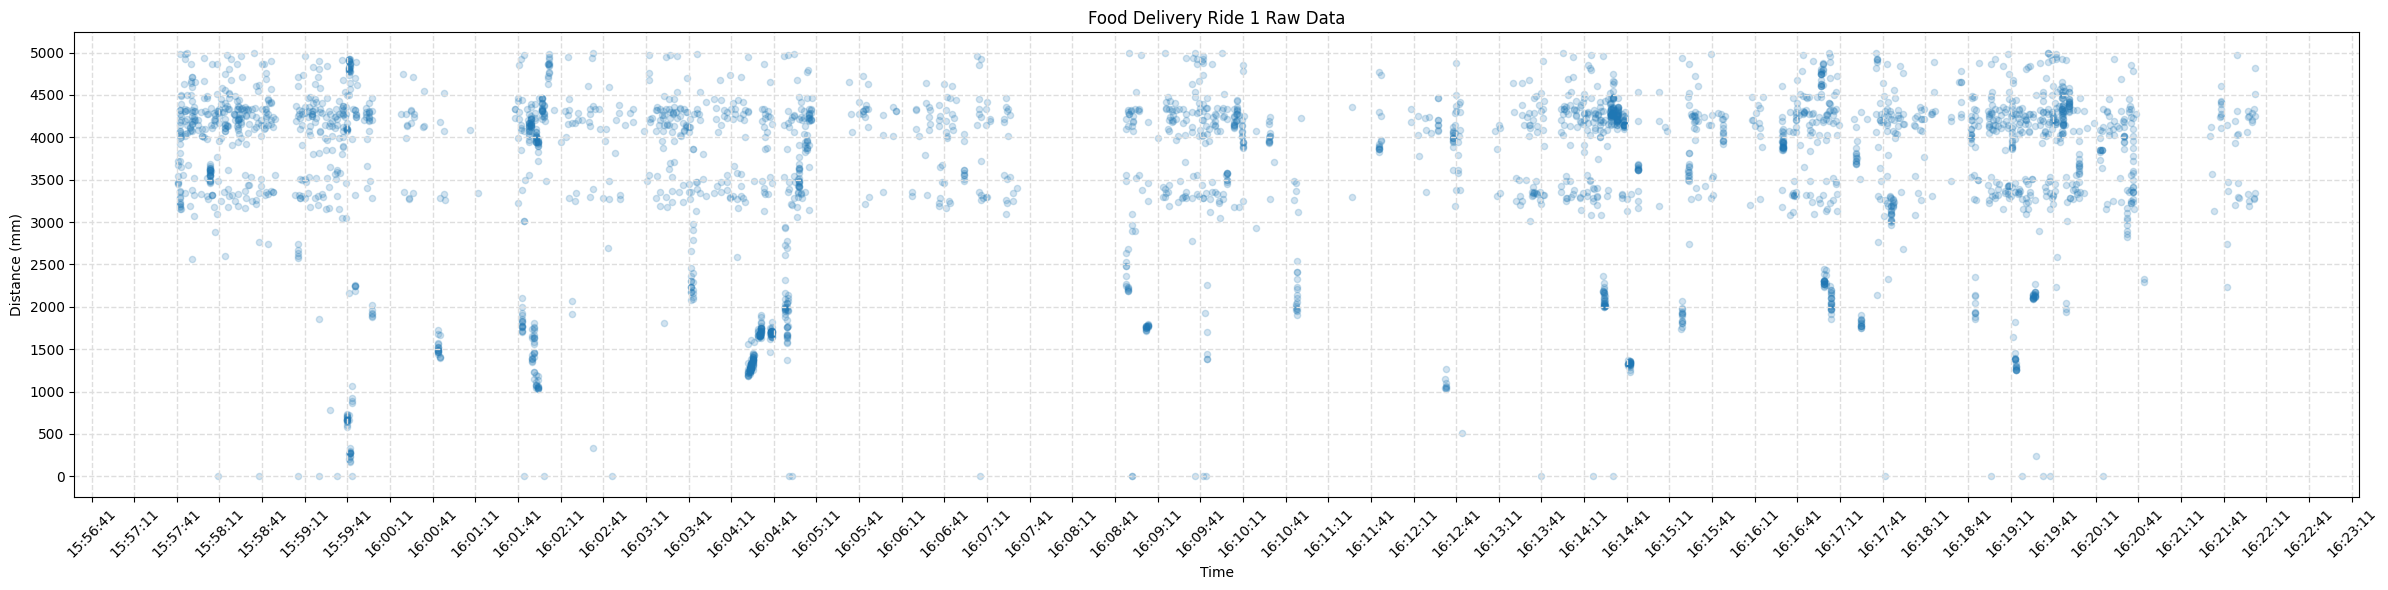

In [11]:
timings, distances, strengths = loader.filter_data_from_file(JURONG_WEST_RIDE, threshold=5000)
cleaned_distances = cleaner.average_clusters(distances)

fig, axes = plt.subplots(figsize=(24, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Food Delivery Ride 1 Raw Data", 30, True)
plt.tight_layout()
plt.show()